# Image Embedding Similarity Search

## Creating image embeddings with features extracted using PyTorch

In [66]:
import faiss
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets

In [48]:
# Check for gpu and initalise model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet101(pretrained=True, progress=True)

print("[INFO] Using Device:", DEVICE)
print(f"[INFO] Loading model: {model.__class__.__name__}")

[INFO] Using Device: cuda
[INFO] Loading model: ResNet


In [49]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset class that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    Source: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = original_tuple + (path,)
        return tuple_with_path

def pooling_output(x, model):
    for layer_name, layer in model._modules.items():
        x = layer(x)
        if layer_name == "avgpool":
            break
    return x

transform = transforms.Compose(
    [
        transforms.Resize(size=[224, 224], interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

def extract_features_paths(data_directory):
    dataset = ImageFolderWithPaths(
        data_directory, transform=transform
    )  # our custom dataset
    # strip away unnecessary info and store path to each image
    img_paths = [dataset.imgs[i][0] for i in range(len(dataset.imgs))]
    # initialize the dataloaders
    dataloader = DataLoader(dataset)

    features = []
    print(f"[INFO][STARTED] Feature Extraction using {model.__class__.__name__}")
    model.to(DEVICE)
    with torch.no_grad():
        model.eval()
        for inputs, labels, paths in tqdm(dataloader):
            result = pooling_output(inputs.to(DEVICE), model)
            features.append(result.cpu().view(1, -1).numpy())
            torch.cuda.empty_cache()

    print(f"[INFO][DONE] Feature Extraction using {model.__class__.__name__}")

    features = np.vstack(features)
    print("[DEBUG]: Preview Features:", features[0])
    print("[DEBUG]: Preview Image Paths:", img_paths[0])
    return features, img_paths

/home/umar-musashi/venv/torchgpu/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [109]:
# TODO: Provide the path to a folder of image files 
data_directory = "/home/umar-musashi/Documents/Musashi Part Images/lobe_dummy"

features, img_paths = extract_features_paths(data_directory)

# The feature length that resnet outputs
dimension = 2048
# Add trained features to FAISS index
index = faiss.IndexFlatL2(dimension) 
index.add(features)

[INFO][STARTED] Feature Extraction using ResNet


100%|██████████| 5921/5921 [00:57<00:00, 102.69it/s]


[INFO][DONE] Feature Extraction using ResNet
[DEBUG]: Preview Features: [0.20680158 0.33582202 0.46328774 ... 0.03407917 0.5526339  0.12803836]
[DEBUG]: Preview Image Paths: /home/umar-musashi/Documents/Musashi Part Images/lobe_dummy/lobe_all_imgs/'por_dirt'_28.737506_Class_1_GJKZA21202214528JT4E 6A267 AA_66_lobe_bot_2021_07_21_22_54_53_0_.jpg


file path:  /home/umar-musashi/Documents/Musashi Part Images/lobe_dummy/lobe_all_imgs/99.96748566627502_77_lobe_bot_2021_08_19_08_56_57_0_.jpg


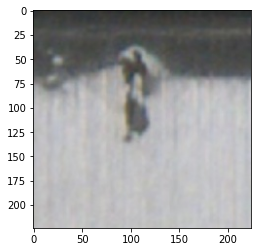

In [111]:
my_index = 3400
query_image = img_paths[my_index]

# query_image = "/home/umar-musashi/Downloads/black-triangle-shape.png"
print("file path: ", query_image)
PIL_img = Image.open(query_image)
# PIL_img = PIL_img.transpose(Image.FLIP_TOP_BOTTOM)
# PIL_img = PIL_img.transpose(Image.FLIP_LEFT_RIGHT)
PIL_img = PIL_img.convert('RGB')
plt.imshow(PIL_img)

query_descriptors shape (1, 2048)
input: [[0.         0.20049192 1.2646335  ... 0.58418    0.92264867 0.14128016]]
input shape: (1, 2048)
input type: <class 'numpy.ndarray'>


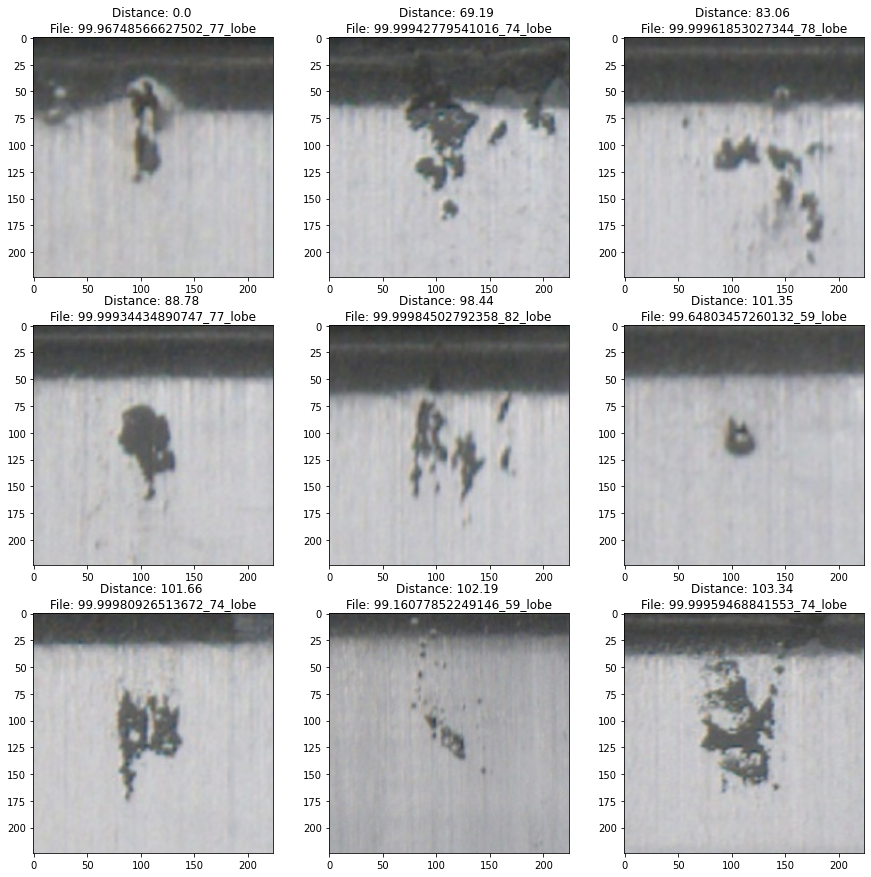

In [112]:
input_tensor = transform(PIL_img)
input_tensor = input_tensor.view(1, *input_tensor.shape)

# Search index for neighbor embeddings
with torch.no_grad():
  model.eval()
  result = pooling_output(input_tensor.to(DEVICE), model)
  query_descriptors = result.cpu().view(1, -1).numpy()
  torch.cuda.empty_cache()

print("query_descriptors shape", query_descriptors.shape)

distances, indices = index.search(query_descriptors, 9)

print("input:", query_descriptors)
print("input shape:", query_descriptors.shape)
print("input type:", type(query_descriptors))

fig, ax = plt.subplots(3, 3, figsize=(15,15))

i = 0
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
  ax_i.imshow(plt.imread(img_paths[file_index]))
  distance = str(float("{0:.2f}".format(distances[0][i])))
  ax_i.set_title(f"Distance: {distance} \nFile: {img_paths[file_index].split('/')[-1][0:25]}")
  i+=1

plt.show()